In [2]:
import torch.nn as nn
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt 
import numpy as np

In [7]:
models = ["Our model ResNet18","ResNet18","ResNet101","PreActResNet","DenseNet", "VGG16"]
accuracy = [92.71, 93.02, 94.82, 95.11, 95.04, 92.64]
num_parameters = [11.2, 11.2, 44.5, 11.2, 8, 15]

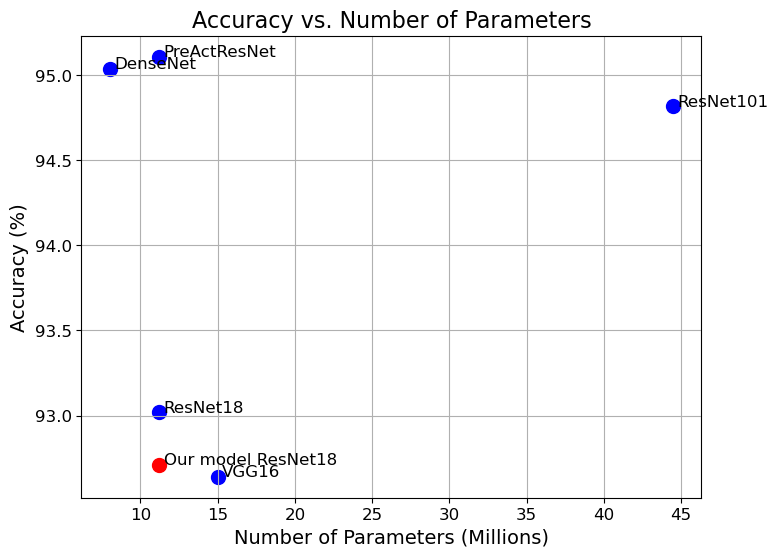

In [10]:
# Create scatter plot
plt.figure(figsize=(8, 6))

# Plot each point
for i, model in enumerate(models):
    color = 'red' if model == "Our model ResNet18" else 'blue'
    plt.scatter(num_parameters[i], accuracy[i], color=color, s=100)  # Red for our model

# Annotate each point with the model name
for i, model in enumerate(models):
    plt.text(num_parameters[i] + 0.3, accuracy[i], model, fontsize=12)

# Labels, title, and grid
plt.xlabel("Number of Parameters (Millions)", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.title("Accuracy vs. Number of Parameters", fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()

Files already downloaded and verified
(4, 3, 32, 32)


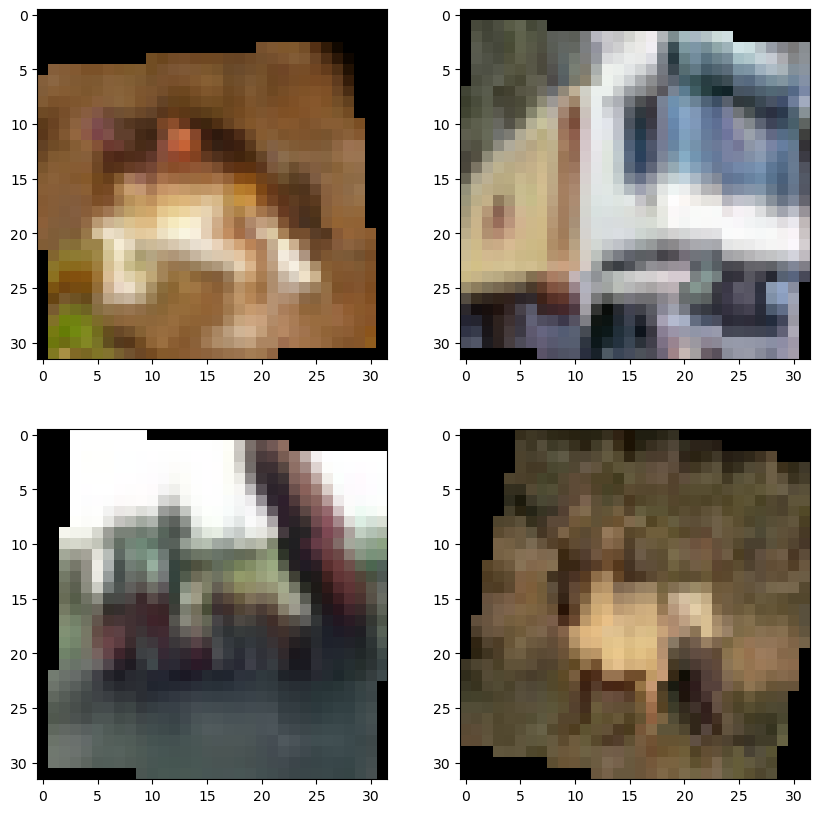

In [8]:
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader

import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.2)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

rootdir = '/opt/img/effdl-cifar10/'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)

trainloader = DataLoader(c10train,batch_size=4,shuffle=False) ### Shuffle to False so that we always see the same images

from matplotlib import pyplot as plt 

### Let's do a figure for each batch
f = plt.figure(figsize=(10,10))

for i,(data,target) in enumerate(trainloader):
    
    data = (data.numpy())
    print(data.shape)
    plt.subplot(2,2,1)
    plt.imshow(data[0].swapaxes(0,2).swapaxes(0,1))
    plt.subplot(2,2,2)
    plt.imshow(data[1].swapaxes(0,2).swapaxes(0,1))
    plt.subplot(2,2,3)
    plt.imshow(data[2].swapaxes(0,2).swapaxes(0,1))
    plt.subplot(2,2,4)
    plt.imshow(data[3].swapaxes(0,2).swapaxes(0,1))

    break

f.savefig('train_DA.png')

In [ ]:
## DATA AUGMENTATION PREPARATION

## No Data Augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])

## Only  Crop and Flip (given)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])

## Only  Scaling and Rotation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.9, 1.1)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    normalize_scratch,
])

## Fancy stuff
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.9, 1.1)),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])

In [ ]:
import torch
import numpy as np

## MixUp Useful Functions
def mixup_data(x, y, alpha=1.0):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = float(np.random.beta(alpha, alpha))  # Ensure float type
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)  # Uses the same device as x

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Computes the mixup loss"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
## their training loop

for batch_idx, (inputs, targets) in enumerate(trainloader):
    if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                   args.alpha, use_cuda)
    inputs, targets_a, targets_b = map(Variable, (inputs,
                                                  targets_a, targets_b))
    outputs = net(inputs)
    loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
    train_loss += loss.data[0]
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
def train_model(model, trainloader, testloader, epochs, is_scheduler, is_mixup):
    train_accuracy_list, test_accuracy_list = [], []
    train_loss_list, test_loss_list = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        if is_mixup:
            for images, labels in trainloader:
                images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=1.0)
                images, labels_a, labels_b = images.to(device), labels_a.to(device), labels_b.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                # Training accuracy
                _, predicted = outputs.max(1)

                correct_train += (lam * predicted.eq(labels_a).sum().item() + (1 - lam) * predicted.eq(labels_b).sum().item())
                total_train += labels_a.size(0)

        else:
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                # Training accuracy
                _, predicted = outputs.max(1)
                correct_train += predicted.eq(labels).sum().item()
                total_train += labels.size(0)

        train_accuracy = 100 * correct_train / total_train
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(running_loss / len(trainloader))

        # Evaluate on test set
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                correct_test += predicted.eq(labels).sum().item()
                total_test += labels.size(0)

        test_accuracy = 100 * (correct_test / total_test)
        test_accuracy_list.append(test_accuracy)
        test_loss_list.append(test_loss / len(testloader))

        # if using a scheduler
        current_lr = optimizer.param_groups[0]['lr']
        if is_scheduler:
            scheduler.step(test_loss / len(testloader))
            if current_lr != optimizer.param_groups[0]['lr']:
                print(f"LEARNING RATE UPDATE TO:{optimizer.param_groups[0]['lr']}")

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {running_loss/len(trainloader):.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, "
              f"Test Acc: {test_accuracy:.2f}% ",
              f"Learning Rate: {optimizer.param_groups[0]['lr']}")

    print("Training complete my boss")

    ############# PLOT THE LOSS AND THE ACCURACY PER EPOCH ####################
    epochs = range(1, num_epochs+1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4)) 
    
    # Loss plot
    axes[0].plot(epochs, train_loss_list, label="Training loss", color="blue")
    axes[0].plot(epochs, test_loss_list, label="Testing loss", color="red")
    axes[0].set_title("Training and testing loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    
    # Accuracy plot
    axes[1].plot(epochs, train_accuracy_list, label="Training accuracy", color="blue")
    axes[1].plot(epochs, test_accuracy_list, label="Testing accuracy", color="red")
    axes[1].set_title("Training and Testing accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].legend()
    
    plt.tight_layout() 
    plt.show()
    #return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list 